In [1]:
!pip install optuna nltk torchinfo -q

In [2]:
import gdown

!gdown --folder https://drive.google.com/drive/folders/15afW9pnFJ42oIDEhAm-N30ZRDA-_g93u?usp=drive_link -q
!gdown --folder https://drive.google.com/drive/folders/1_Qjbb2cAa_eW_WmjmVwTfEufwfhDjUIh?usp=drive_link -q

*****
## Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import time
import nltk
import json

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score

import torch
import optuna
import torch.nn as nn
import torch.optim as optim

nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize

from collections import Counter

from torch.utils.data import DataLoader, Dataset
from torchinfo import summary
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.tensorboard import SummaryWriter
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence

# set working directory
import os
# os.chdir(r'd:\Programing\Youtube_Comment_Sentiments_&_Type_Analysis')
os.chdir(f'/kaggle/working')

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!



*****
## Dataset Loading and vectorizing

In [6]:
train_df = pd.read_csv('./data/train_dataset.csv')
test_df = pd.read_csv('./data/test_dataset.csv')
valid_df = pd.read_csv('./data/valid_dataset.csv')
sentiment_df = pd.read_csv('./data/evaluation_dataset.csv')

In [7]:
train_df.shape, test_df.shape, valid_df.shape, sentiment_df.shape

((15393, 4), (1925, 4), (1924, 4), (8842, 4))

In [8]:
train_df.columns, sentiment_df.columns

(Index(['comment_v1', 'comment_v2', 'type', 'sentiment'], dtype='object'),
 Index(['clean_comment_v1', 'clean_comment_v2', 'sentiment', 'type'], dtype='object'))

In [9]:
train_x = train_df['comment_v1']
train_y = train_df[['sentiment', 'type']]

test_x = test_df['comment_v1']
test_y = test_df[['sentiment', 'type']]

valid_x = valid_df['comment_v1']
valid_y = valid_df[['sentiment', 'type']]

sentiment_x = sentiment_df['clean_comment_v1']
sentiment_y = sentiment_df[['sentiment', 'type']]

*****
## Building Vocabulary

In [10]:
data = train_x.tolist() + test_x.tolist() + valid_x.tolist() + sentiment_x.tolist()
data = " ".join(data)

In [11]:
tokens = word_tokenize(data)
print(f"Total Number of tokens: {len(tokens)}")

Total Number of tokens: 265985


In [12]:
# build vocab
vocab = {
    '<unk>': 0,
    '<pad>': 1
}

for token in Counter(tokens).keys():
    if token not in vocab:
        vocab[token] = len(vocab)

print(f"Vocabulary Size: {len(vocab)}")

Vocabulary Size: 39849


In [13]:
with open('data/vocab.json', 'w') as file:
    json.dump(vocab, file, indent=4, ensure_ascii=False)

*****
## Model and Dataset Class

In [14]:
class SentimentDataset(Dataset):
    def __init__(self, x, y, vocab):
        self.x = x.astype(str).tolist()
        self.y_sentiment = torch.LongTensor(y['sentiment'].values)
        self.y_type = torch.LongTensor(y['type'].values)
        self.vocab = vocab

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        tokens = word_tokenize(self.x[idx])
        ids = [self.vocab.get(t, self.vocab['<unk>']) for t in tokens]
        return torch.LongTensor(ids), self.y_sentiment[idx], self.y_type[idx]

In [15]:
# collate function for padding
def collate_fn(batch, pad_id, max_len=100):
    seqs, senti_label, type_label = zip(*batch)
    # turncation
    seqs = [seq[:max_len] if len(seq) > max_len else seq for seq in seqs]

    # padding
    length = torch.LongTensor([len(seq) for seq in seqs])
    pad_seqs = pad_sequence(seqs, batch_first=True, padding_value=pad_id)

    senti_label = torch.stack(senti_label)
    type_label = torch.stack(type_label)

    return pad_seqs, length, senti_label, type_label

In [16]:
class SentimentLSTM(nn.Module):
    def __init__ (self, vocab_size, embed_dim, hidden_dim, sentiment_out, type_out, pad_id):
        super(SentimentLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_id)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)

        # classifiers
        self.sentiment = nn.Linear(hidden_dim, sentiment_out)
        self.type_ = nn.Linear(hidden_dim, type_out)

    def forward(self, x, lengths):
        embd = self.embedding(x)
        packed = pack_padded_sequence(embd, lengths.cpu(), batch_first=True, enforce_sorted=False)
        opt, (h_s, c_s) = self.lstm(packed)

        features = h_s[-1]      # batch, hidden_state
        sentiment_out = self.sentiment(features)
        type_out = self.type_(features)

        return sentiment_out, type_out

*****
## Training Functions

In [17]:
def train_eval_loop(model, data_loader, optimizer, is_train=False, device='cuda'):
    losses = 0.0
    correct_sentiment = 0
    correct_type = 0

    criterion = nn.CrossEntropyLoss().to(device)

    # set mode (train / eval)
    model.train() if is_train else model.eval()
    for x, lengths, y_sentiment, y_type in data_loader:
        x, lengths, y_sentiment, y_type = x.to(device), lengths.to(device), y_sentiment.to(device), y_type.to(device)

        # forward pass
        y_sen, y_ty = model(x, lengths)

        # calculate loss
        loss_sentiment = criterion(y_sen, y_sentiment)
        loss_type = criterion(y_ty, y_type)

        loss = loss_sentiment + loss_type

        if is_train:
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update grad
            optimizer.step()

        # calculate total losses and accuracy
        losses += loss.item()
        _, pred_sentiment = torch.max(y_sen, 1)
        _, pred_type = torch.max(y_ty, 1)

        correct_sentiment += (pred_sentiment == y_sentiment).sum().item()
        correct_type += (pred_type == y_type).sum().item()

    avg_loss = losses / len(data_loader)
    avg_acc_sentiment = correct_sentiment / len(data_loader.dataset)
    avg_acc_type = correct_type / len(data_loader.dataset)

    return avg_loss, avg_acc_sentiment, avg_acc_type, ((avg_acc_sentiment+avg_acc_type) / 2)


In [18]:
def train_model(
        model,
        train_loader,
        val_loader,
        optimizer,
        scheduler,
        n_epochs,
        device='cuda',
        patience=10, # wait for next 10 epoch to stop training and return the best state model
        is_monitor=False, # it will be true only for training
        is_stopping=False # true if we want to stop training early if no better state found
    ):

    # initialize the tensorboard
    writer = SummaryWriter('runs/training_logs') if is_monitor else None

    # total training losses and accuracy
    train_losses = []
    train_acc_sentiments = []
    train_acc_types = []
    train_acc_avgs = []

    # total validation losses and accuracy
    val_losses = []
    val_acc_sentiments = []
    val_acc_types = []
    val_acc_avgs = []

    best_val_loss = float('inf')
    counter = 0

    # training loop
    for epoch in range(n_epochs):
        # training
        train_loss, train_acc_sentiment, train_acc_type, train_acc_avg = train_eval_loop(
            model,
            train_loader,
            optimizer,
            is_train=True,
            device=device
        )

        # storing the results
        train_losses.append(train_loss)
        train_acc_sentiments.append(train_acc_sentiment)
        train_acc_types.append(train_acc_type)
        train_acc_avgs.append(train_acc_avg)

        # valudation
        val_loss, val_acc_sentiment, val_acc_type, val_acc_avg = train_eval_loop(
            model,
            val_loader,
            optimizer,
            is_train=False,
            device=device
        )

        # storing the vvalidation results
        val_losses.append(val_loss)
        val_acc_sentiments.append(val_acc_sentiment)
        val_acc_types.append(val_acc_type)
        val_acc_avgs.append(val_acc_avg)

        if is_monitor:
            print(f"Epoch: {epoch+1}/{n_epochs}, "
                  f"Train_loss: {train_loss:.4f}, Val_loss: {val_loss:.4f}, Train Acc: {train_acc_avg:.4f}, Val Acc: {val_acc_avg:.4f}")

        # tensorboard logging
        if writer is not None:
            writer.add_scalar('Loss/train', train_loss, epoch)
            writer.add_scalar('Loss/val', val_loss, epoch)

            writer.add_scalar('Accuracy/train_sentiment', train_acc_sentiment, epoch)
            writer.add_scalar('Accuracy/train_type', train_acc_type, epoch)
            writer.add_scalar('Accuracy/train_avg', train_acc_avg, epoch)

            writer.add_scalar('Accuracy/val_sentiment', val_acc_sentiment, epoch)
            writer.add_scalar('Accuracy/val_type', val_acc_type, epoch)
            writer.add_scalar('Accuracy/val_avg', val_acc_avg, epoch)

        # setup the scheduler based on validation loss
        scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            counter = 0
        else:
            counter += 1
            if is_stopping:
                if counter >= patience and epoch > 50:
                    print(f"Early stopping at epoch {epoch+1}")
                    break

        if writer is not None:
            writer.flush()

    model.load_state_dict(best_model_state)   # loading the best model states
    model.to(device)

    if writer is not None:
        writer.close()

    return model, {
        'train_losses': train_losses,
        'train_acc_sentiments': train_acc_sentiments,
        'train_acc_types': train_acc_types,
        'train_acc_avgs': train_acc_avgs,
        'val_losses': val_losses,
        'val_acc_sentiments': val_acc_sentiments,
        'val_acc_types': val_acc_types,
        'val_acc_avgs': val_acc_avgs
    }

*****
## Hyper Parameter Tuning Functions

In [19]:
def objective_shallow(trail, train_dataset, val_dataset, sentiment_out, type_out, vocab, max_len, device='cuda'):
    # suggested hyper parameters
    embed_dim = trail.suggest_categorical('embed_dim', [512, 728, 1024, 2048])
    hidden_dim = trail.suggest_categorical('hidden_dim', [32, 64, 128, 256, 512])
    # dropout_rate = trail.suggest_float('dropout_rate', 0.2, 0.5, step=0.05)
    n_epochs = trail.suggest_int('n_epochs', 20, 200, step=20)
    learning_rate = trail.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    batch_size = trail.suggest_categorical('batch_size', [64, 128, 256, 512])
    optimizer_name = trail.suggest_categorical('optimizer', ['Adam', 'SGD', 'RMSprop'])
    weight_decay = trail.suggest_float('weight_decay', 1e-5, 1e-2, log=True)

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        pin_memory=True,
        drop_last=True,
        collate_fn=lambda b: collate_fn(b, pad_id=vocab['<pad>'], max_len=max_len)
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        pin_memory=True,
        drop_last=False,
        collate_fn=lambda b: collate_fn(b, pad_id=vocab['<pad>'], max_len=max_len)
    )

    # init model
    model = SentimentLSTM(
        vocab_size=len(vocab),
        embed_dim=embed_dim,
        hidden_dim=hidden_dim,
        sentiment_out=sentiment_out,
        type_out=type_out,
        pad_id=vocab['<pad>']
    ).to(device)

    # select optimizer
    if optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    elif optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    else:
        optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    scheduler = ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5,
        patience=5
    )

    _, metrics = train_model(
        model = model,
        train_loader = train_loader,
        val_loader = val_loader,
        optimizer = optimizer,
        scheduler = scheduler,
        n_epochs = n_epochs,
        device = device,
        is_stopping=True
    )

    # return the best validation loss as the objective to minimize
    return min(metrics['val_losses'])

In [20]:
def tune_hyperparameters(train_dataset, val_dataset, sentiment_out, type_out, vocab, max_len, device='cuda', n_trails=50):
    # create optuna study with minize validaiton loss
    pruner = optuna.pruners.MedianPruner(n_warmup_steps=5)
    study = optuna.create_study(direction='minimize', pruner=pruner)
    start = time.time()
    study.optimize(
        lambda trail: objective_shallow(
            trail,
            train_dataset,
            val_dataset,
            sentiment_out,
            type_out,
            vocab=vocab,
            max_len=max_len,
            device=device
        ),
        n_trials=n_trails,
        n_jobs=2,
        show_progress_bar=True
        )

    elapsed = time.time() - start
    h = int(elapsed // 3600)
    m = int((elapsed % 3600) // 60)

    print(f"\nLSTM Tuning Time: {h}h, {m}m.")

    print("Number of finised trails::", len(study.trials))
    print("\nBest trial:")
    trial = study.best_trial

    print(f"Validation Loss: {trial.value:.4f}")
    print("Best hyperparameters:")
    for key, value in trial.params.items():
        print(f"{key}: {value}")

    return study.best_params

*****
## Perform Hyperparameter Tuning

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    print(f"Device: {torch.cuda.get_device_name()}")
    print(f"Number of Device :{torch.cuda.device_count()}")
else:
    print("Device: CPU")

Device: Tesla T4
Number of Device :2


In [22]:
train_dataset = SentimentDataset(train_x, train_y, vocab)
val_dataset = SentimentDataset(valid_x, valid_y, vocab)
test_data = SentimentDataset(test_x, test_y, vocab)
sentiment_data = SentimentDataset(sentiment_x, sentiment_y, vocab)

sentiment_out = train_y['sentiment'].nunique()
type_out = train_y['type'].nunique()
max_len=100

In [23]:
best_param = tune_hyperparameters(
    train_dataset,
    val_dataset,
    sentiment_out,
    type_out, 
    vocab=vocab, 
    device=device,
    max_len=max_len,
    n_trails=100 
)

[I 2026-01-15 03:24:56,077] A new study created in memory with name: no-name-04e60224-a470-4e6e-9609-265dd77e1eb5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2026-01-15 03:30:50,248] Trial 1 finished with value: 1.6264588832855225 and parameters: {'embed_dim': 2048, 'hidden_dim': 128, 'n_epochs': 40, 'learning_rate': 0.00013346645464684854, 'batch_size': 256, 'optimizer': 'RMSprop', 'weight_decay': 0.0003086894057441507}. Best is trial 1 with value: 1.6264588832855225.
[I 2026-01-15 03:32:24,549] Trial 0 finished with value: 1.908290058374405 and parameters: {'embed_dim': 1024, 'hidden_dim': 32, 'n_epochs': 100, 'learning_rate': 3.7994088059406124e-05, 'batch_size': 512, 'optimizer': 'Adam', 'weight_decay': 0.002533437715991762}. Best is trial 1 with value: 1.6264588832855225.
Early stopping at epoch 52
[I 2026-01-15 03:35:49,765] Trial 2 finished with value: 1.5064763724803925 and parameters: {'embed_dim': 1024, 'hidden_dim': 256, 'n_epochs': 60, 'learning_rate': 0.006317310162421365, 'batch_size': 256, 'optimizer': 'Adam', 'weight_decay': 0.0004895829494113404}. Best is trial 2 with value: 1.5064763724803925.
Early stopping at epoch 52

In [ ]:
# import torch
# import gc

# # Delete variables holding GPU tensors/models
# # del model, optimizer, tensor   # uncomment and add your variable names

# gc.collect()
# torch.cuda.empty_cache()
# torch.cuda.ipc_collect()


In [24]:
model = SentimentLSTM(
    vocab_size=len(vocab),
    embed_dim=best_param['embed_dim'],
    hidden_dim=best_param['hidden_dim'],
    sentiment_out=sentiment_out,
    type_out=type_out,
    pad_id=vocab['<pad>']
).to(device)

# model training with best parameters to track the model lerning performance
train_loader = DataLoader(
    train_dataset,
    batch_size=best_param['batch_size'],
    shuffle=True,
    pin_memory=True,
    drop_last=True,
    collate_fn=lambda b: collate_fn(b, pad_id=vocab['<pad>'], max_len=max_len)
)
val_loader = DataLoader(
    val_dataset,
    batch_size=best_param['batch_size'],
    shuffle=False,
    pin_memory=True,
    drop_last=True,
    collate_fn=lambda b: collate_fn(b, pad_id=vocab['<pad>'], max_len=max_len)
)

optimizer = optim.Adam(model.parameters(), lr=best_param['learning_rate'], weight_decay=best_param['weight_decay']) # l2 regularization
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

In [25]:
%reload_ext tensorboard
%tensorboard --logdir runs

<IPython.core.display.Javascript object>

## Training LSTM Model

In [26]:
start = time.time()
model, metrics = train_model(
    model,
    train_loader,
    val_loader,
    optimizer,
    scheduler,
    n_epochs = best_param['n_epochs'],
    device=device,
    is_monitor=True,
    is_stopping=False
)
elapsed = time.time() - start
h = int(elapsed // 3600)
m = int((elapsed % 3600) // 60)
print(f"\LSTM Time required {h}h, {m}m.")

Epoch: 1/100, Train_loss: 1.8501, Val_loss: 1.6264, Train Acc: 0.6082, Val Acc: 0.6629
Epoch: 2/100, Train_loss: 1.4851, Val_loss: 1.5088, Train Acc: 0.6963, Val Acc: 0.6814
Epoch: 3/100, Train_loss: 1.4433, Val_loss: 1.4698, Train Acc: 0.7028, Val Acc: 0.6952
Epoch: 4/100, Train_loss: 1.4057, Val_loss: 1.4574, Train Acc: 0.7101, Val Acc: 0.6926
Epoch: 5/100, Train_loss: 1.2767, Val_loss: 1.4417, Train Acc: 0.7417, Val Acc: 0.6928
Epoch: 6/100, Train_loss: 1.0923, Val_loss: 1.4151, Train Acc: 0.7863, Val Acc: 0.7131
Epoch: 7/100, Train_loss: 0.9159, Val_loss: 1.4575, Train Acc: 0.8223, Val Acc: 0.7061
Epoch: 8/100, Train_loss: 0.8013, Val_loss: 1.5387, Train Acc: 0.8479, Val Acc: 0.7027
Epoch: 9/100, Train_loss: 0.6938, Val_loss: 1.6302, Train Acc: 0.8685, Val Acc: 0.6965
Epoch: 10/100, Train_loss: 0.6135, Val_loss: 1.6587, Train Acc: 0.8825, Val Acc: 0.7066
Epoch: 11/100, Train_loss: 0.4229, Val_loss: 1.8477, Train Acc: 0.9242, Val Acc: 0.7024
Epoch: 12/100, Train_loss: 0.3037, Val_lo

*****
## Evaluation Function

In [27]:
def plot_learning_curve(history):
    plt.figure(figsize=(8, 6))
    plt.plot(history['train_losses'], label='Train Loss')
    plt.plot(history['val_losses'], label='Validation Loss')
    plt.plot(history['train_acc_avgs'], label='Train Accuracy')
    plt.plot(history['val_acc_avgs'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Loss & Accuracy')
    plt.title('Learning Curve')
    plt.legend()

In [28]:
def evaluate_model(model, test_loader, sentiment_decoder, type_decoder=None, device='cuda', is_type=False):
    sentiment_true = []
    sentiment_pred = []
    type_true = []
    type_pred = []

    model.eval()
    with torch.no_grad():
        for x, length, y_sen, y_type in test_loader:
            x, length, y_sen, y_type = x.to(device), length.to(device), y_sen.to(device), y_type.to(device)
            pred_senti, pred_type = model(x, length)

            _, pred_senti = torch.max(pred_senti, 1)
            _, pred_type = torch.max(pred_type, 1)

            sentiment_true.extend(y_sen.cpu().tolist())
            sentiment_pred.extend(pred_senti.cpu().tolist())

            if is_type:
                type_true.extend(y_type.cpu().tolist())
                type_pred.extend(pred_type.cpu().tolist())

    sentiment_true = np.array(sentiment_true)
    sentiment_pred = np.array(sentiment_pred)

    if is_type:
        type_true = np.array(type_true)
        type_pred = np.array(type_pred)


    # sentiment Metrics
    print(f"\n================== SENTIMENT METRICS ==================")
    print(f"Accuracy: {accuracy_score(sentiment_true, sentiment_pred):.4f}")
    print(f"F1 Score: {f1_score(sentiment_true, sentiment_pred, average='weighted'):.4f}")
    print(f"Precision: {precision_score(sentiment_true, sentiment_pred, average='weighted'):.4f}")
    print(f"Recall: {recall_score(sentiment_true, sentiment_pred, average='weighted'):.4f}")

    print(f"\nClassification Report:")
    print(classification_report(
        sentiment_true,
        sentiment_pred,
        target_names=sentiment_decoder.classes_
    ))

    # type Metrics
    print(f"\n==================== TYPE METRICS ====================")
    print(f"Accuracy: {accuracy_score(type_true, type_pred):.4f}")
    print(f"F1 Score: {f1_score(type_true, type_pred, average='weighted'):.4f}")
    print(f"Precision: {precision_score(type_true, type_pred, average='weighted'):.4f}")
    print(f"Recall: {recall_score(type_true, type_pred, average='weighted'):.4f}")

    print(f"\nClassification Report:")
    print(classification_report(
        type_true,
        type_pred,
        target_names=type_decoder.classes_
    ))

    # sentiment confusion matrix
    cm_sentiment = confusion_matrix(sentiment_true, sentiment_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_sentiment, annot=True, fmt='d', cmap='Blues',
                xticklabels=sentiment_decoder.classes_,
                yticklabels=sentiment_decoder.classes_
                )
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Sentiment Confusion Matrix')
    plt.show()

    # type confusion matrix
    if is_type:
        print()
        cm_type = confusion_matrix(type_true, type_pred)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm_type, annot=True, fmt='d', cmap='Blues',
                    xticklabels=type_decoder.classes_,
                    yticklabels=type_decoder.classes_
                    )
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Type Confusion Matrix')
        plt.show()

*****
## Model Evaluation

In [29]:
sentiment_decoder = joblib.load('./models/sentiment_encoder.pkl')
type_decoder = joblib.load('./models/type_encoder.pkl')

In [30]:
test_loader = DataLoader(
    test_data,
    batch_size=best_param['batch_size'],
    shuffle=False,
    pin_memory=True,
    collate_fn=lambda b: collate_fn(b, pad_id=vocab['<pad>'], max_len=max_len)
)
sentiment_loader = DataLoader(
    sentiment_data,
    batch_size=best_param['batch_size'],
    shuffle=False,
    pin_memory=True,
    collate_fn=lambda b: collate_fn(b, pad_id=vocab['<pad>'], max_len=max_len)
)

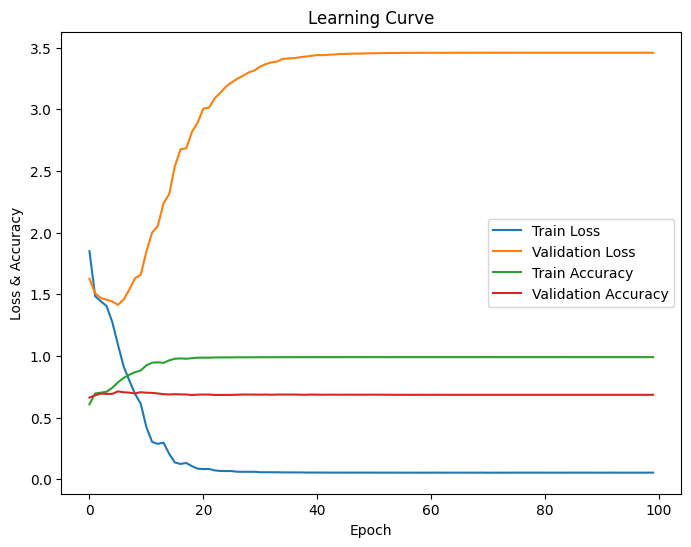

In [31]:
plot_learning_curve(metrics)


================== SENTIMENT METRICS ==================
Accuracy: 0.7091
F1 Score: 0.7088
Precision: 0.7087
Recall: 0.7091

Classification Report:
              precision    recall  f1-score   support

    negative       0.64      0.63      0.64       486
     neutral       0.73      0.75      0.74       765
    positive       0.73      0.71      0.72       674

    accuracy                           0.71      1925
   macro avg       0.70      0.70      0.70      1925
weighted avg       0.71      0.71      0.71      1925


==================== TYPE METRICS ====================
Accuracy: 0.6795
F1 Score: 0.6793
Precision: 0.6797
Recall: 0.6795

Classification Report:
              precision    recall  f1-score   support

   emotional       0.77      0.77      0.77      1009
 informative       0.57      0.58      0.57       378
     opinion       0.58      0.60      0.59       377
 promotional       0.62      0.47      0.53        17
    question       0.60      0.53      0.57       144

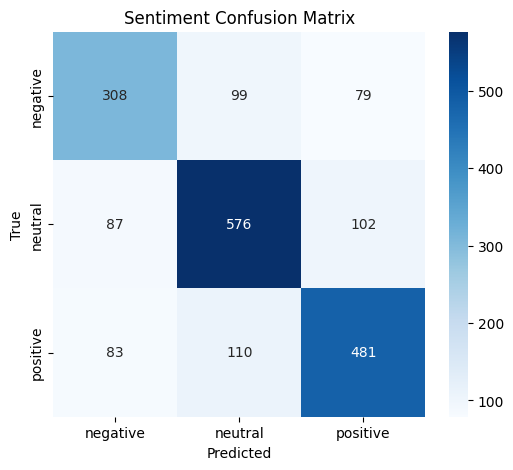

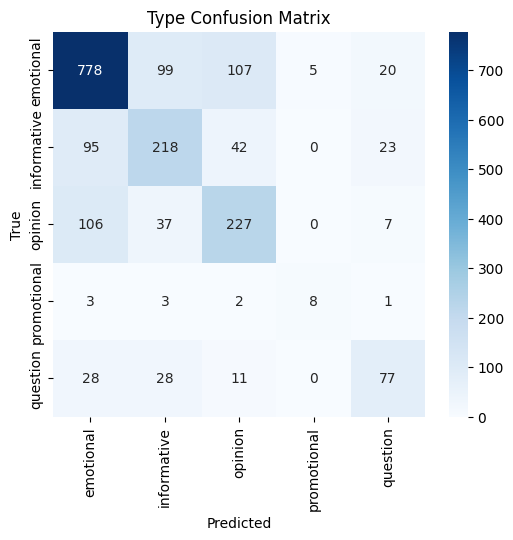

In [32]:
# evaluate on test dataset
evaluate_model(model, test_loader, sentiment_decoder, type_decoder, device=device, is_type=True)


================== SENTIMENT METRICS ==================
Accuracy: 0.5533
F1 Score: 0.5537
Precision: 0.5594
Recall: 0.5533

Classification Report:
              precision    recall  f1-score   support

    negative       0.59      0.48      0.53      2992
     neutral       0.46      0.54      0.50      2784
    positive       0.62      0.63      0.63      3066

    accuracy                           0.55      8842
   macro avg       0.56      0.55      0.55      8842
weighted avg       0.56      0.55      0.55      8842


==================== TYPE METRICS ====================
Accuracy: 0.5412
F1 Score: 0.7023
Precision: 1.0000
Recall: 0.5412

Classification Report:
              precision    recall  f1-score   support

   emotional       1.00      0.54      0.70      8842
 informative       0.00      0.00      0.00         0
     opinion       0.00      0.00      0.00         0
 promotional       0.00      0.00      0.00         0
    question       0.00      0.00      0.00         0

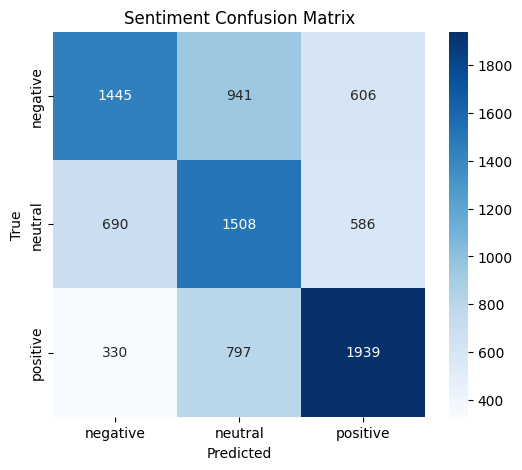

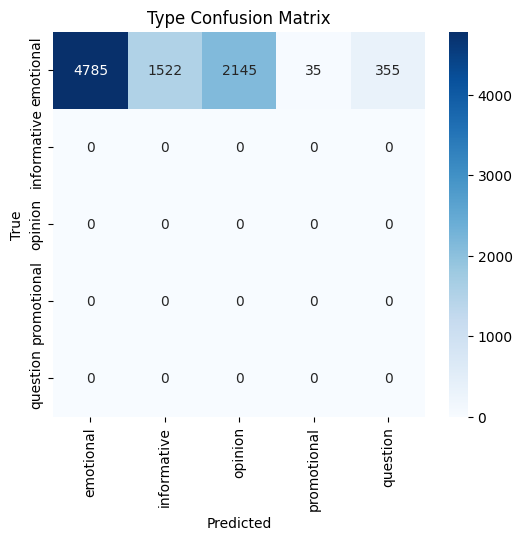

In [33]:
# evaluate on separate sentiment dataset
evaluate_model(model, sentiment_loader, sentiment_decoder, type_decoder, device=device, is_type=True)

In [34]:
def get_pred(model, x):
    tokens = word_tokenize(x)
    ids = [vocab.get(t, vocab['<unk>']) for t in tokens]

    # turncate till max length 100
    ids = ids[:max_len]
    ids = torch.LongTensor(ids).unsqueeze(0).to(device)
    lengths = torch.LongTensor([ids.size(1)]).to(device)

    model.eval()
    with torch.no_grad():
        y_sen, y_ty = model(ids, lengths)
    _, y_sen = torch.max(y_sen, 1)
    _, y_ty = torch.max(y_ty, 1)
    y_sen = y_sen.item()
    y_ty = y_ty.item()
    return y_sen, y_ty

sentiment, _ = get_pred(model, sentiment_x.iloc[0])
print(f"Predicted sentiment: {sentiment}; Actual sentiment: {sentiment_y.iloc[0]['sentiment']}")

Predicted sentiment: 2; Actual sentiment: 2


In [35]:
summary(model)

Layer (type:depth-idx)                   Param #
SentimentLSTM                            --
├─Embedding: 1-1                         29,010,072
├─LSTM: 1-2                              97,536
├─Linear: 1-3                            99
├─Linear: 1-4                            165
Total params: 29,107,872
Trainable params: 29,107,872
Non-trainable params: 0

In [36]:
torch.save(model, './models/sentiment_lstm.pth')

*****
## Training BiLSTM Model

In [39]:
class SentimentBiLSTM(nn.Module):
    def __init__ (self, vocab_size, embed_dim, hidden_dim, sentiment_out, type_out, pad_id):
        super(SentimentBiLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_id)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, num_layers=1, bidirectional=True)
        self.dropout = nn.Dropout(0.1)
        
        # classifiers
        self.sentiment = nn.Linear(hidden_dim * 2, sentiment_out)
        self.type_ = nn.Linear(hidden_dim * 2, type_out)

    def forward(self, x, lengths):
        embd = self.embedding(x)
        packed = pack_padded_sequence(embd, lengths.cpu(), batch_first=True, enforce_sorted=False)
        opt, (h_s, c_s) = self.lstm(packed)

        # last layer forward + backward
        features = torch.cat((h_s[-2,:,:], h_s[-1,:,:]), dim=1)
        sentiment_out = self.sentiment(features)
        type_out = self.type_(features)

        return sentiment_out, type_out

In [40]:
bilstm_model = SentimentBiLSTM(
    vocab_size=len(vocab),
    embed_dim=best_param['embed_dim'],
    hidden_dim=best_param['hidden_dim'],
    sentiment_out=sentiment_out,
    type_out=type_out,
    pad_id=vocab['<pad>']
).to(device)

In [41]:
start = time.time()
model, metrics = train_model(
    bilstm_model,
    train_loader,
    val_loader,
    optimizer,
    scheduler,
    n_epochs = best_param['n_epochs'],
    device=device,
    is_monitor=True,
    is_stopping=False
)
elapsed = time.time() - start
h = int(elapsed // 3600)
m = int((elapsed % 3600) // 60)
print(f"\LSTM Time required {h}h, {m}m.")

Epoch: 1/100, Train_loss: 2.6958, Val_loss: 2.6915, Train Acc: 0.2959, Val Acc: 0.3069
Epoch: 2/100, Train_loss: 2.6960, Val_loss: 2.6915, Train Acc: 0.2957, Val Acc: 0.3069
Epoch: 3/100, Train_loss: 2.6958, Val_loss: 2.6915, Train Acc: 0.2959, Val Acc: 0.3069
Epoch: 4/100, Train_loss: 2.6958, Val_loss: 2.6915, Train Acc: 0.2959, Val Acc: 0.3069
Epoch: 5/100, Train_loss: 2.6958, Val_loss: 2.6915, Train Acc: 0.2959, Val Acc: 0.3069
Epoch: 6/100, Train_loss: 2.6959, Val_loss: 2.6915, Train Acc: 0.2958, Val Acc: 0.3069
Epoch: 7/100, Train_loss: 2.6958, Val_loss: 2.6915, Train Acc: 0.2962, Val Acc: 0.3069
Epoch: 8/100, Train_loss: 2.6959, Val_loss: 2.6915, Train Acc: 0.2959, Val Acc: 0.3069
Epoch: 9/100, Train_loss: 2.6957, Val_loss: 2.6915, Train Acc: 0.2960, Val Acc: 0.3069
Epoch: 10/100, Train_loss: 2.6958, Val_loss: 2.6915, Train Acc: 0.2960, Val Acc: 0.3069
Epoch: 11/100, Train_loss: 2.6958, Val_loss: 2.6915, Train Acc: 0.2959, Val Acc: 0.3069
Epoch: 12/100, Train_loss: 2.6958, Val_lo

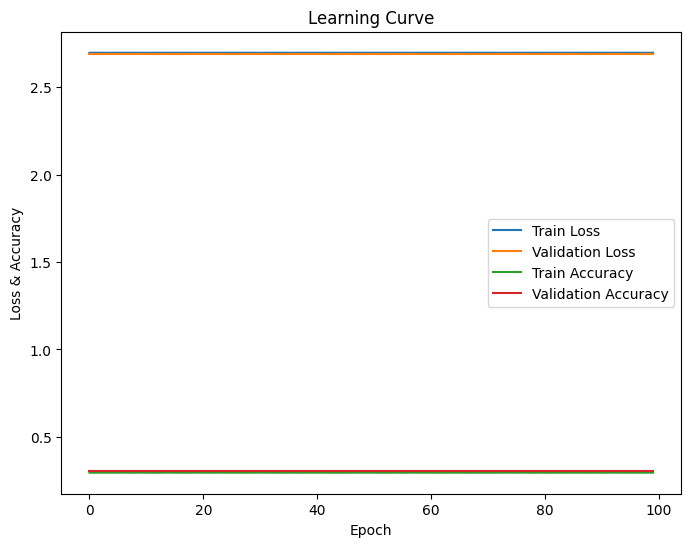

In [42]:
plot_learning_curve(metrics)


================== SENTIMENT METRICS ==================
Accuracy: 0.3371
F1 Score: 0.3404
Precision: 0.3561
Recall: 0.3371

Classification Report:
              precision    recall  f1-score   support

    negative       0.25      0.38      0.30       486
     neutral       0.41      0.34      0.37       765
    positive       0.37      0.30      0.33       674

    accuracy                           0.34      1925
   macro avg       0.34      0.34      0.34      1925
weighted avg       0.36      0.34      0.34      1925


==================== TYPE METRICS ====================
Accuracy: 0.2592
F1 Score: 0.2968
Precision: 0.3563
Recall: 0.2592

Classification Report:
              precision    recall  f1-score   support

   emotional       0.53      0.38      0.44      1009
 informative       0.16      0.07      0.10       378
     opinion       0.20      0.17      0.18       377
 promotional       0.01      0.29      0.02        17
    question       0.15      0.15      0.15       144

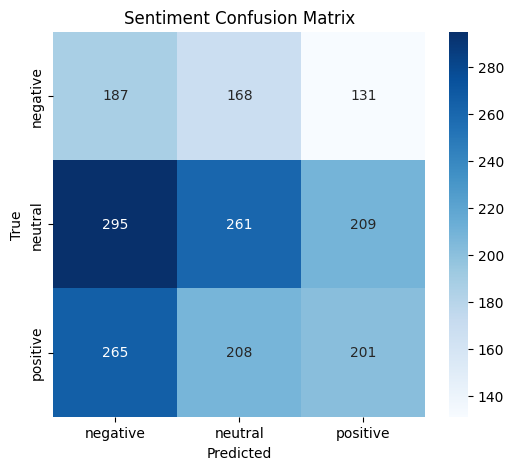

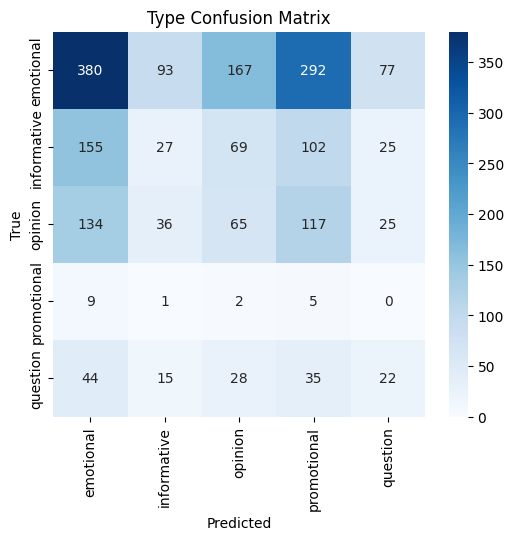

In [43]:
# evaluate on test dataset
evaluate_model(model, test_loader, sentiment_decoder, type_decoder, device=device, is_type=True)


================== SENTIMENT METRICS ==================
Accuracy: 0.3323
F1 Score: 0.3313
Precision: 0.3337
Recall: 0.3323

Classification Report:
              precision    recall  f1-score   support

    negative       0.32      0.34      0.33      2992
     neutral       0.33      0.37      0.35      2784
    positive       0.35      0.28      0.31      3066

    accuracy                           0.33      8842
   macro avg       0.33      0.33      0.33      8842
weighted avg       0.33      0.33      0.33      8842


==================== TYPE METRICS ====================
Accuracy: 0.3833
F1 Score: 0.5542
Precision: 1.0000
Recall: 0.3833

Classification Report:
              precision    recall  f1-score   support

   emotional       1.00      0.38      0.55      8842
 informative       0.00      0.00      0.00         0
     opinion       0.00      0.00      0.00         0
 promotional       0.00      0.00      0.00         0
    question       0.00      0.00      0.00         0

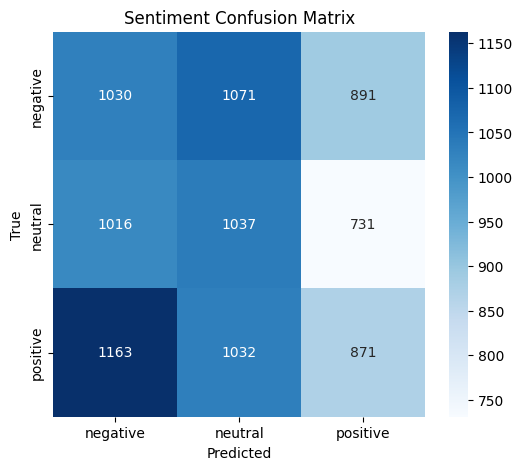

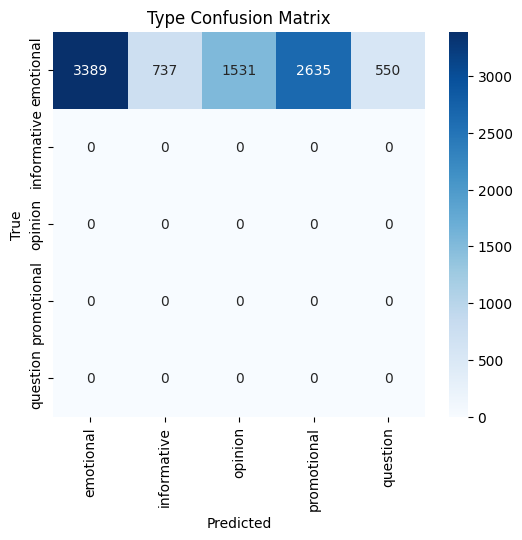

In [44]:
# evaluate on separate sentiment dataset
evaluate_model(model, sentiment_loader, sentiment_decoder, type_decoder, device=device, is_type=True)

In [45]:
summary(model)

Layer (type:depth-idx)                   Param #
SentimentBiLSTM                          --
├─Embedding: 1-1                         29,010,072
├─LSTM: 1-2                              195,072
├─Dropout: 1-3                           --
├─Linear: 1-4                            195
├─Linear: 1-5                            325
Total params: 29,205,664
Trainable params: 29,205,664
Non-trainable params: 0

In [46]:
torch.save(model, './models/sentiment_bilstm.pth')